In [30]:
import dataclasses
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from q1physrl import phys

In [39]:
with open("/home/matt/Quakespasm/quakespasm/Quake/accel_svr.txt") as f:
    lines = f.readlines()

In [40]:
def parse_dataframe(lines, prefix, float32_cols, float64_cols):
    records = [json.loads(l.split(' ', 1)[1].strip())
                   for l in lines if l.startswith(prefix)]   
    df = pd.DataFrame.from_records(records)
    
    for col in float32_cols:
        df[col] = df[col].astype('int32').view('float32')

    for col in float64_cols:
        df[col] = df[col].astype('int64').view('float64')
    
    return df

In [41]:
df = parse_dataframe(lines, '@@@FRAME_INPUT@@@',
                     ['yaw', 'pitch', 'roll', 'fmove', 'smove', 'button2', 'velx', 'vely', 'velz', 'z'],
                     ['time', 'host_frametime'])

In [48]:
pd.Series.describe((df.yaw * 256 / 360) % 1)

count    258.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yaw, dtype: float64

In [26]:
np.diff(np.array(df.yaw.value_counts().index.sort_values())) * 256 / 360

array([2.6140625e+01, 3.9062500e-03, 5.8593750e-02, 2.1875000e-01,
       1.6406250e-01, 1.6015625e-01, 2.3828125e-01, 4.5312500e-01,
       8.1640625e-01, 1.1718750e-02, 6.4843750e-01, 2.2656250e-01,
       5.2343750e-01, 4.4531250e-01, 1.2812500e+00, 8.7890625e-01,
       8.9843750e-02, 1.0000000e+00, 1.0937500e+00, 7.0312500e-02,
       9.4140625e-01, 1.9531250e-02, 8.9062500e-01, 8.3203125e-01,
       1.9921875e-01, 4.2187500e-01, 7.8125000e-01, 3.1250000e-02,
       3.1250000e-02, 3.5156250e-02, 3.9062500e-03, 5.8593750e-02,
       7.8125000e-03, 3.5156250e-02, 1.6015625e-01, 3.7890625e-01,
       1.2500000e-01, 1.3671875e-01, 2.4218750e-01, 5.3906250e-01,
       1.1328125e-01, 7.0312500e-02, 2.2265625e-01, 2.8125000e-01,
       2.8515625e-01, 8.7890625e-01, 2.1093750e-01, 1.1718750e-02,
       1.2890625e-01, 7.4218750e-02, 4.4140625e-01, 5.0781250e-02,
       3.9062500e-03, 1.6015625e-01, 1.2890625e-01, 1.2500000e-01,
       1.5625000e-01, 8.2031250e-02, 2.3437500e-01, 1.0937500e

In [10]:
df.fmove.value_counts()

400.0    263
0.0       43
200.0      1
Name: fmove, dtype: int64

In [5]:
inputs = phys.Inputs.from_df(df)
player_state = phys.PlayerState.from_df(df)

next_player_state = phys.apply(inputs, player_state)

real_df = player_state.to_df().iloc[1:].reset_index().drop(['index', 'onground', 'jumpreleased'], axis=1)
sim_df = next_player_state.to_df().iloc[:-1].reset_index().drop(['index', 'onground', 'jumpreleased'], axis=1)

/home/matt/100m-rl/q1physrl/phys.py:99: RuntimeWarning: invalid value encountered in true_divide
  wish_vel / unclipped_wish_speed[:, None],
/home/matt/100m-rl/q1physrl/phys.py:104: RuntimeWarning: invalid value encountered in true_divide
  (wish_speed / unclipped_wish_speed),
/home/matt/100m-rl/q1physrl/phys.py:89: RuntimeWarning: invalid value encountered in true_divide
  return np.where((speed > 0)[:, None], h_vel * (new_speed / speed)[:, None], h_vel)


In [42]:
df.z

0      32.843201
1      32.529602
2      31.591202
3      30.863201
4      29.978401
         ...    
302    24.011585
303    24.011585
304    24.011585
305    24.011585
306    24.011585
Name: z, Length: 307, dtype: float32

In [37]:
(df.z[0] * 16).astype(int) / 16 + 1/16

32.875

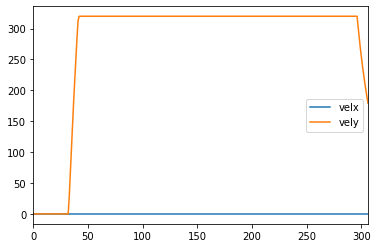

In [14]:
df[['velx', 'vely']].plot()

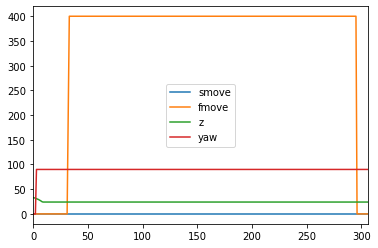

In [6]:
df[['smove', 'fmove', 'z', 'yaw']].plot()

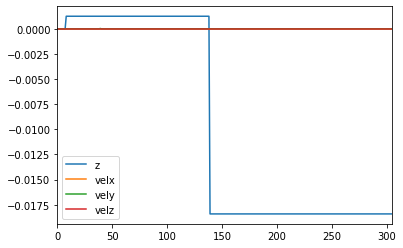

In [7]:
(real_df - sim_df).plot()

# Profiling

In [23]:
N = 1000

inputs2 = phys.Inputs.from_df(pd.concat([inputs.to_df() for _ in range(N)], axis=0))
player_state2 = phys.PlayerState.from_df(pd.concat([player_state.to_df() for _ in range(N)], axis=0))

In [29]:
%time phys.apply(inputs2, player_state2)
None

CPU times: user 7.06 ms, sys: 0 ns, total: 7.06 ms
Wall time: 9.55 ms


In [10]:
%prun -s cumtime phys.apply(inputs2, player_state2)
None

In [11]:
%load_ext line_profiler

In [12]:
%lprun -f phys._angle_vectors phys.apply(inputs2, player_state2)
None